In [5]:
#реализация по частотному распределению

import pywt
import pylab
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy import signal
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from pylab import *

# функция чтения из edf-файла
def data_extraxtion(file_name, chanel_num, start_sec, stop_sec):
    
    f = pyedflib.EdfReader(file_name)  
    n = f.signals_in_file  
    signal_labels = f.getSignalLabels() 
    sigbufs = np.zeros((n, f.getNSamples()[0]))

    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
        
    f.close()
    
    # частота дискретизации == 125 Гц
    x_data = [i for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]
    y_data = [sigbufs[chanel_num][i] for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]

    return x_data, y_data

# формирование массива названий файлов
names_arr = ['Pavel', 'Elena', 'Mihail', 'Evgeny']
str_arr = []

for str_1 in names_arr:
    for str_2 in ['_1', '_2', '_3', '_4', '_5', '_6']:
        try:
            _, _ =  data_extraxtion(str_1 + str_2 + '.edf', 4, 5, 15)
            str_arr.append(str_1 + str_2)
        except:
            pass

#обозначаем колличество секций для формирования признаков
section_num = 60
samples_num = len(str_arr)

chanel_num_arr = [3, 4]      # номера рассматриваемых каналов
start_sec = 0                # начало с этой секунды
stop_sec = 55                # заканчиваем на этой секунде

columns_ = ['Users']
for i in range(section_num):
    columns_.append('S_' + str(i + 1))

index_ = [i for i in range(samples_num * len(chanel_num_arr))]
features_df = pd.DataFrame(index = index_, columns = columns_)

# датафрейм с признаками:
for i in range(len(index_)):

    features_df['Users'][i] = str_arr[i // 2].rstrip("_123456")
    x_data, y_data = data_extraxtion(str_arr[i // 2] + '.edf', chanel_num_arr[i % 2], start_sec, stop_sec)
    freqs, psd = signal.welch(y_data)

    len_freqs = freqs[-1:][0]
    len_psd = len(psd)

    for j in range(section_num):
        area = np.trapz(psd[int(len_psd * j / section_num) : int(len_psd * (j + 1) / section_num)], \
                        dx = len_freqs / section_num)
        features_df['S_' + str(j + 1)][i] = area
        
# перемешиваем
features_df = features_df.sample(frac = 1).reset_index(drop = True)

names_arr = np.array(names_arr)
y_data = [np.where(names_arr == str_)[0][0] + 1 for str_ in features_df['Users']]
x_data = [[features_df[features_df.columns[i]][j] for j in range(len(features_df.index))] for i in range(1, len(features_df.columns))]
x_data = np.array(x_data).transpose()


# разделение на train|test
trsh = 0.8
tmp = int(trsh * len(y_data))

x_train = x_data[:tmp]
y_train = y_data[:tmp]

x_test = x_data[tmp:]
y_test = y_data[tmp:]

# классификация + кросс-валидация:
clf_svc_cv = SVC(kernel = 'linear', random_state = 777, C = 10)
res_svc = cross_val_score(clf_svc_cv, x_data, y_data, cv = 5)
print('accuracy for SVC: ', np.mean(res_svc))

clf_rf_cv = RandomForestClassifier(n_estimators = 20, random_state = 42)
res_rf = cross_val_score(clf_rf_cv, x_data, y_data, cv = 5)
print('accuracy for RF: ', np.mean(res_rf))

clf_knn_cv = KNeighborsClassifier(n_neighbors = 6)
res = cross_val_score(clf_knn_cv, x_data, y_data, cv = 5)
print('accuracy for kNN: ', np.mean(res))

accuracy for SVC:  0.9047619047619048
accuracy for RF:  0.9714285714285715
accuracy for kNN:  0.8031746031746032


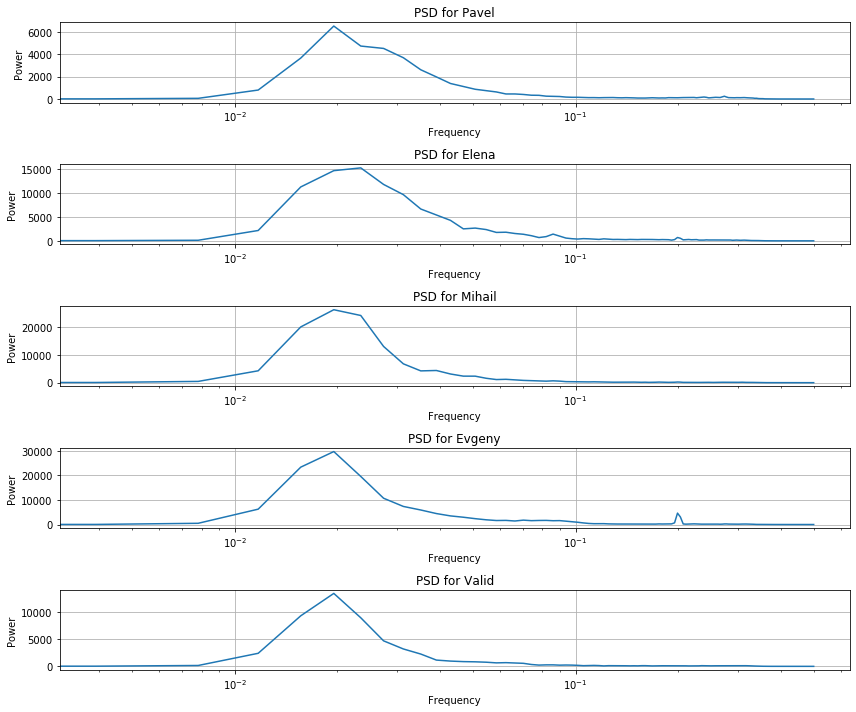

In [6]:
# вид спектральной плотности мощности для разных людей

str_arr = ['Pavel_1', 'Elena_1', 'Mihail_1', 'Evgeny_1', 'Valid']
plt.figure(figsize = (12, 10))
tmp = 1

for str_ in str_arr:
    
    x_data, y_data = data_extraxtion(str_ + '.edf', 4, 0, 55)
    freqs, psd = signal.welch(y_data)
        
    subplot(len(str_arr), 1, tmp)
    tmp += 1
    
    plt.semilogx(freqs, psd)
    #lt.plot(freqs, psd)
    plt.title('PSD for ' + str_.rstrip("_123456"))
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.grid()
    plt.tight_layout()